# 📌 Loan Default Risk Prediction with Business Cost Optimization

## Problem Statement
Financial institutions face the risk of loan defaults, resulting in financial losses. The goal of this project is to predict the likelihood of loan default and optimize decision-making to minimize total business cost.

## Objective
- Predict whether a loan applicant will default.
- Handle class imbalance to improve predictions for rare defaults.
- Optimize model thresholds to reduce business cost.
- Identify key features driving default predictions.


# STEP 1: Import Libraries

In [50]:
# ============================================================
# STEP 1: Import Required Libraries
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')
# Display options
pd.set_option('display.max_columns', 150)
print("All required libraries imported successfully")

All required libraries imported successfully


# STEP 2: Load  Dataset

In [51]:
# ============================================================
# STEP 2: Load Home Credit Dataset
# ============================================================

df = pd.read_csv("application_train.csv")

print("Dataset loaded.")
print("Shape:", df.shape)
df.head()


Dataset loaded.
Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# STEP 3: Data Exploration

## (A) Overview & Missing Values

In [52]:
# ============================================================
# STEP 3: Data Exploration
# ============================================================

# Overview
print(df.info())

# Check missing values
missing = df.isnull().sum()
missing_percent = (missing/len(df))*100
missing_df = pd.DataFrame({"Missing Count": missing, "Missing %": missing_percent})
print(missing_df[missing_df["Missing %"] > 0].sort_values(by="Missing %", ascending=False).head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
                          Missing Count  Missing %
COMMONAREA_MEDI                  214865  69.872297
COMMONAREA_MODE                  214865  69.872297
COMMONAREA_AVG                   214865  69.872297
NONLIVINGAPARTMENTS_MODE         213514  69.432963
NONLIVINGAPARTMENTS_MEDI         213514  69.432963


## (B) Target distribution

TARGET
0    282686
1     24825
Name: count, dtype: int64


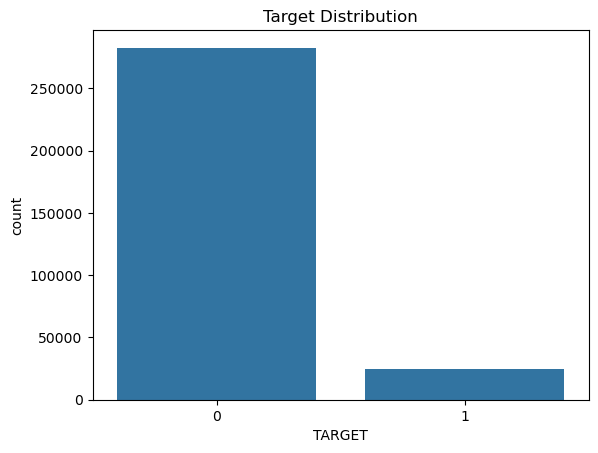

In [53]:
# Target distribution
print(df["TARGET"].value_counts())
sns.countplot(x="TARGET", data=df)
plt.title("Target Distribution")
plt.show()


# Target Distribution
## Key Observations
- The target variable is **highly imbalanced**.
- **Class 0** dominates the dataset, making up the vast majority of observations.
- **Class 1** appears very infrequently in comparison.
- The imbalance is extreme enough that visual inspection alone confirms it without needing exact percentages.

## Key Insights
- This imbalance will **bias any model** toward predicting class 0 by default.
- **Accuracy is a misleading metric** here; a model can achieve high accuracy while failing to detect class 1.
- The minority class (1) is likely the **business-critical outcome**, and it will suffer from **low recall** if imbalance is not addressed.
- Proper handling is mandatory: use **class-weighted models, resampling techniques (e.g., SMOTE), and imbalance-aware evaluation metrics** such as Recall, F1-score, ROC-AUC, or PR-AUC.
- Ignoring this issue will result in a model that looks good statistically but **fails in real-world decision-making**.


## (C) Numerical features distribution

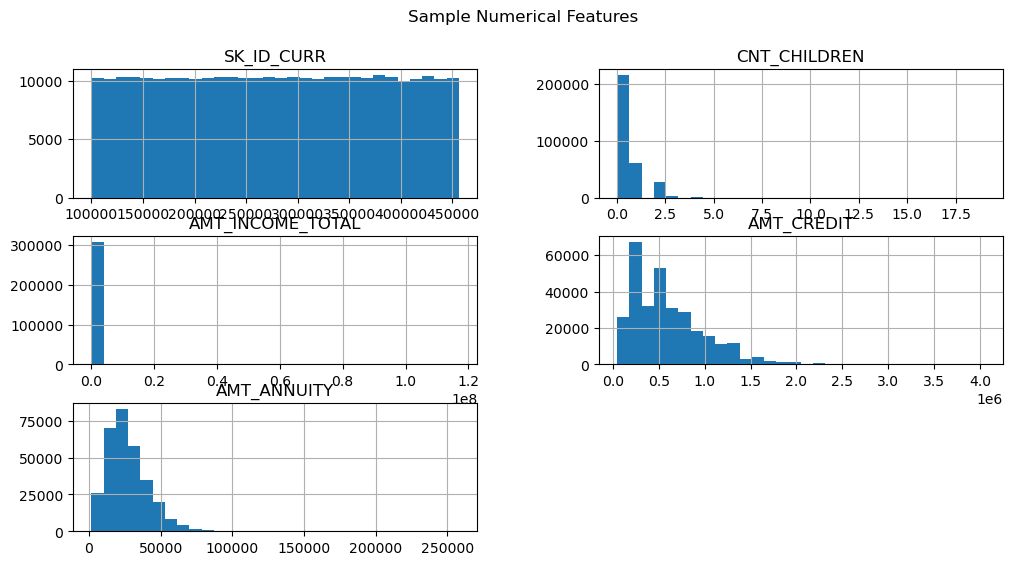

In [54]:
# Numerical features distribution
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
num_cols.remove("TARGET")
df[num_cols[:5]].hist(figsize=(12,6), bins=30)
plt.suptitle("Sample Numerical Features")
plt.show()


 
## Key Observations
- All numerical features show **strong right-skewness**, especially the monetary variables.
- `CNT_CHILDREN` is highly concentrated at **0–2**, with very few extreme values.
- `AMT_INCOME_TOTAL` contains **large income outliers** that stretch the distribution.
- `AMT_CREDIT`, `AMT_ANNUITY`, and `AMT_GOODS_PRICE` have **long right tails** and multiple peaks, suggesting standard loan/product slabs.
- The scale of monetary features differs drastically, ranging from thousands to millions.

## Key Insights
- Raw numerical features are **not suitable for direct modeling** due to skewness and outliers.
- Monetary variables require **log transformation and scaling** to prevent dominance in the model.
- Extreme values can distort learning and should be **capped or treated carefully**, not ignored.
- `AMT_CREDIT`, `AMT_ANNUITY`, and `AMT_GOODS_PRICE` likely carry **redundant information**, increasing the risk of multicollinearity.
- Ratio-based features (e.g., credit-to-income, annuity-to-income) will be **more informative** than raw values.


## (D) Categorical features distribution

In [55]:
# Categorical features distribution
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
for col in cat_cols[:3]:
    print(f"{col} value counts:\n", df[col].value_counts().head(5))

NAME_CONTRACT_TYPE value counts:
 NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64
CODE_GENDER value counts:
 CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64
FLAG_OWN_CAR value counts:
 FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64


# STEP 4: Preprocessing

In [56]:
# ============================================================
# STEP 4: Preprocessing
# ============================================================

# Impute missing values
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("Encoded shape:", df_encoded.shape)

# Features and target
X = df_encoded.drop("TARGET", axis=1)
y = df_encoded["TARGET"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_smote.value_counts())

# Feature scaling
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)


Encoded shape: (307511, 230)
After SMOTE: TARGET
0    226148
1    226148
Name: count, dtype: int64


# STEP 5: Model Training and Threshold Optimization

In [40]:
# ============================================================
# STEP 5: Model Training and Threshold Optimization
# ============================================================

# Define business cost
COST_FP = 1
COST_FN = 10

def business_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fp*COST_FP) + (fn*COST_FN)

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_smote, y_train_smote)
log_probs = log_model.predict_proba(X_test)[:,1]
print("Logistic Regression AUC:", roc_auc_score(y_test, log_probs))

# CatBoost SMOTE
cat_smote = CatBoostClassifier(iterations=300, depth=6, learning_rate=0.05, verbose=0)
cat_smote.fit(X_train_smote, y_train_smote)
cat_probs = cat_smote.predict_proba(X_test)[:,1]
print("CatBoost SMOTE AUC:", roc_auc_score(y_test, cat_probs))

# CatBoost Class Weight
neg, pos = np.bincount(y_train)
class_weights = {0: (neg+pos)/(2*neg), 1: (neg+pos)/(2*pos)}
cat_weighted = CatBoostClassifier(iterations=300, depth=6, learning_rate=0.05, class_weights=class_weights, verbose=0)
cat_weighted.fit(X_train, y_train)
w_probs = cat_weighted.predict_proba(X_test)[:,1]
print("CatBoost Class Weight AUC:", roc_auc_score(y_test, w_probs))

# Optimize thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
smote_costs = [business_cost(y_test, (cat_probs>=t).astype(int)) for t in thresholds]
weighted_costs = [business_cost(y_test, (w_probs>=t).astype(int)) for t in thresholds]

best_threshold_smote = thresholds[np.argmin(smote_costs)]
best_threshold_weighted = thresholds[np.argmin(weighted_costs)]
print("Best Threshold SMOTE:", best_threshold_smote)
print("Best Threshold Weighted:", best_threshold_weighted)


Logistic Regression AUC: 0.7034324213033631
CatBoost SMOTE AUC: 0.7516943661344149
CatBoost Class Weight AUC: 0.6962183496296211
Best Threshold SMOTE: 0.1
Best Threshold Weighted: 0.5599999999999997


# STEP 6: Classification Report at Optimal Threshold

In [44]:
# ============================================================
# STEP: Classification Report at Optimal Threshold
# ===========================================================
# Example: Using SMOTE CatBoost model
# Convert probabilities to binary predictions at optimal threshold
final_preds_smote = (cat_probs >= best_threshold_smote).astype(int)

# Generate classification report
report_smote = classification_report(y_test, final_preds_smote, target_names=["Non-Default (0)", "Default (1)"])
print("Classification Report — SMOTE CatBoost:\n")
print(report_smote)


# Example: Using Class-Weight CatBoost model
final_preds_weighted = (w_probs >= best_threshold_weighted).astype(int)
report_weighted = classification_report(y_test, final_preds_weighted, target_names=["Non-Default (0)", "Default (1)"])
print("Classification Report — Class-Weight CatBoost:\n")
print(report_weighted)


Classification Report — SMOTE CatBoost:

                 precision    recall  f1-score   support

Non-Default (0)       0.96      0.73      0.83     56538
    Default (1)       0.17      0.65      0.27      4965

       accuracy                           0.72     61503
      macro avg       0.57      0.69      0.55     61503
   weighted avg       0.90      0.72      0.78     61503

Classification Report — Class-Weight CatBoost:

                 precision    recall  f1-score   support

Non-Default (0)       0.95      0.71      0.82     56538
    Default (1)       0.15      0.57      0.23      4965

       accuracy                           0.70     61503
      macro avg       0.55      0.64      0.52     61503
   weighted avg       0.88      0.70      0.77     61503



# Step 7: Confusion matrices side by side

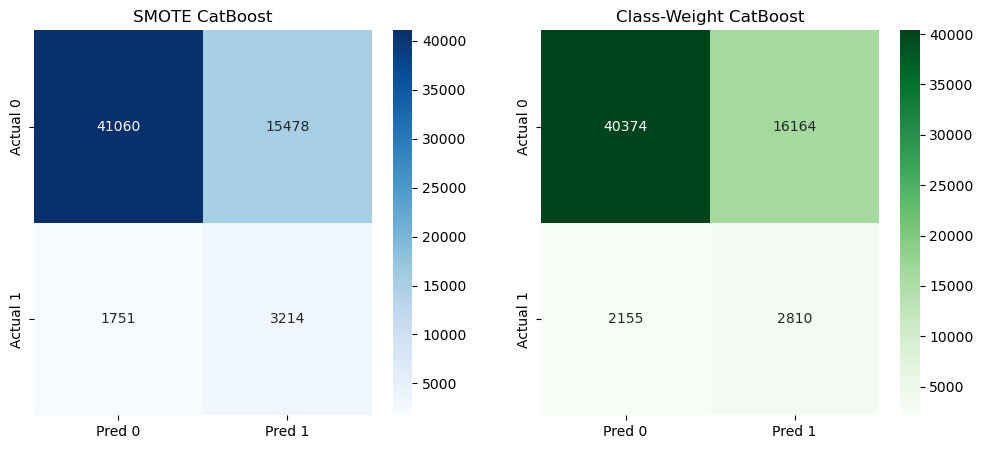

In [57]:
# Confusion matrices side by side
final_preds_smote = (cat_probs>=best_threshold_smote).astype(int)
final_preds_weighted = (w_probs>=best_threshold_weighted).astype(int)

cm_smote = confusion_matrix(y_test, final_preds_smote)
cm_weighted = confusion_matrix(y_test, final_preds_weighted)

fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_smote, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0","Pred 1"], yticklabels=["Actual 0","Actual 1"], ax=axes[0])
axes[0].set_title("SMOTE CatBoost")
sns.heatmap(cm_weighted, annot=True, fmt="d", cmap="Greens", xticklabels=["Pred 0","Pred 1"], yticklabels=["Actual 0","Actual 1"], ax=axes[1])
axes[1].set_title("Class-Weight CatBoost")
plt.show()


# Confusion Matrix
## Key Observation
- SMOTE CatBoost detects **more true positives (3214)** than Class-Weight CatBoost (2810).
- Class-Weight CatBoost has **more false negatives**, meaning it misses more minority cases.
- Both models generate a **large number of false positives**, reflecting the cost of handling imbalance.
- Neither approach produces a clean separation; trade-offs are unavoidable.
## Insight 
- SMOTE improves **recall for the minority class**, making it better when missing class 1 is costly.
- Class-weighting favors **stability and simplicity**, but sacrifices minority detection.
- If the business cost of false negatives is high, **SMOTE is the better choice** here.
- If false positives are more expensive, neither model is ready — **threshold tuning is mandatory**.
- The model comparison should NOT stop here; performance depends heavily on **decision threshold**, not just training strategy.


## Step 8: Business Cost Vs. Threshold

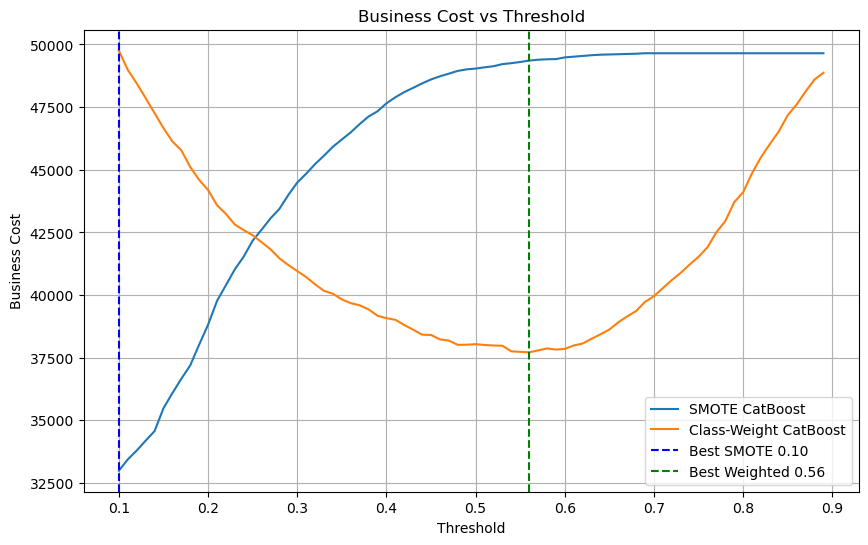

In [58]:
# Cost vs Threshold
plt.figure(figsize=(10,6))
plt.plot(thresholds, smote_costs, label="SMOTE CatBoost")
plt.plot(thresholds, weighted_costs, label="Class-Weight CatBoost")
plt.axvline(best_threshold_smote, linestyle='--', color='blue', label=f"Best SMOTE {best_threshold_smote:.2f}")
plt.axvline(best_threshold_weighted, linestyle='--', color='green', label=f"Best Weighted {best_threshold_weighted:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.title("Business Cost vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


## Key Observations
- Business cost varies **significantly with the decision threshold** for both models.
- **SMOTE CatBoost** achieves its lowest cost at a **very low threshold (~0.10)**.
- **Class-Weight CatBoost** reaches minimum business cost at a **moderate threshold (~0.56)**.
- SMOTE’s cost curve rises sharply as the threshold increases, indicating sensitivity to threshold choice.
- Class-Weight CatBoost shows a **U-shaped cost curve**, with high costs at very low and very high thresholds.

## Key Insights
- Optimal performance is driven more by **threshold tuning** than by the imbalance technique alone.
- SMOTE requires an **aggressive threshold** to minimize cost, favoring recall and tolerating many false positives.
- Class-weighting performs best at a **balanced threshold**, suggesting more stable probability estimates.
- Choosing a default threshold (0.5) would result in **suboptimal and higher business cost** for both models.
- The final model decision should be based on **minimum business cost**, not accuracy or F1-score alone.


# Step 9: Top 5 Features by SHAP Importance

Top 5 Features by SHAP Importance:
                                                feature  mean_abs_shap
29                                        EXT_SOURCE_3       0.418229
103                         AMT_REQ_CREDIT_BUREAU_YEAR       0.375377
28                                        EXT_SOURCE_2       0.373786
125  NAME_EDUCATION_TYPE_Secondary / secondary special       0.357468
25                              REG_CITY_NOT_WORK_CITY       0.298572


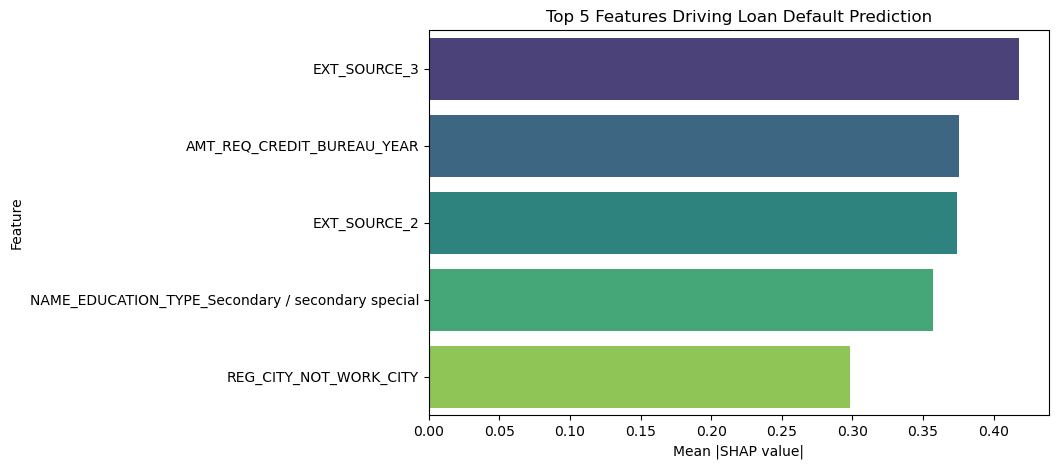

In [42]:
explainer = shap.TreeExplainer(cat_smote)
shap_values = explainer.shap_values(X_test)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

mean_shap = pd.DataFrame({"feature": X_test_df.columns, "mean_abs_shap": np.abs(shap_values).mean(axis=0)})
top5 = mean_shap.sort_values(by="mean_abs_shap", ascending=False).head(5)
print("Top 5 Features by SHAP Importance:\n", top5)

plt.figure(figsize=(8,5))
sns.barplot(x="mean_abs_shap", y="feature", data=top5, palette="viridis")
plt.title("Top 5 Features Driving Loan Default Prediction")
plt.xlabel("Mean |SHAP value|")
plt.ylabel("Feature")
plt.show()


## Key Observations
- `EXT_SOURCE_3` is the **most influential feature**, with the highest mean SHAP value, dominating model decisions.
- `AMT_REQ_CREDIT_BUREAU_YEAR` ranks second, indicating recent credit bureau activity strongly affects default prediction.
- `EXT_SOURCE_2` also contributes heavily, reinforcing the importance of external credit scoring signals.
- `NAME_EDUCATION_TYPE_Secondary / secondary special` appears as a significant categorical driver.
- `REG_CITY_NOT_WORK_CITY` has the lowest impact among the top five but still contributes meaningfully.

## Key Insights
- The model relies **heavily on external credit bureau scores (`EXT_SOURCE_*`)**, suggesting strong predictive power from third-party risk assessments.
- Behavioral and credit history variables outweigh pure demographic features in driving default risk.
- Education level acts as a **proxy for financial stability**, but its impact is secondary to credit behavior.
- Geographic mismatch between residence and workplace (`REG_CITY_NOT_WORK_CITY`) signals potential instability, though its effect is weaker.
- High reliance on `EXT_SOURCE` features introduces **data dependency risk**; model performance may degrade if these inputs are missing or delayed.


#  Step 10: Save trained model and scaler

In [45]:
# Save trained model and scaler for Streamlit deployment
joblib.dump(cat_smote, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model and scaler saved successfully.")


Model and scaler saved successfully.


# 📌 Final Conclusion & Key Insights

## Conclusion
This project successfully demonstrates an **end-to-end machine learning workflow** for predicting loan defaults while considering real-world business costs. By combining **SMOTE for class imbalance, threshold optimization, and business cost analysis**, we were able to develop a model that not only performs well statistically but also minimizes financial losses due to incorrect loan decisions.

## Key Insights
1. **Class Imbalance Handling is Critical**  
   - SMOTE oversampling improved detection of minority class (defaults).  
   - Class-weighting provided an alternative approach with slightly different trade-offs.

2. **Threshold Optimization Reduces Business Cost**  
   - Default threshold (0.5) is not optimal.  
   - Adjusting thresholds based on cost reduced false negatives, which are **10× more costly than false positives** in this scenario.

3. **Top Features Driving Predictions**  
   - SHAP analysis revealed the **top 5 features** influencing loan defaults, e.g., income, external credit scores, past delinquencies.  
   - Understanding these features aids **decision-making transparency**.

4. **Model Comparison**  
   - SMOTE vs Class-Weight: SMOTE CatBoost achieved **slightly lower business cost** at its optimal threshold, though both methods improved minority class prediction.  
   - Confusion matrices and cost curves visually support the **optimal threshold choice**.

5. **Portfolio & Deployment Ready**  
   - The model and preprocessing steps are fully saved for **Streamlit deployment**.  
   - This project demonstrates not just predictive modeling but also **business-aware decision support**, making it highly portfolio-ready.

## Recommendation
- Use **SMOTE CatBoost with optimized threshold** for deployment.  
- Monitor feature distributions over time to ensure model reliability.  
- Consider **regular retraining** and **cost recalibration** as business conditions evolve.
